In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from itertools import combinations

import statsmodels
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.diagnostic as dg
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf

from scipy.stats import shapiro
from scipy.stats import mannwhitneyu

import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
data = pd.read_csv('VTB_1day.txt', sep=",", parse_dates=['<DATE>'])
data

,<TICKER>,<PER>,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
0,VTBR,D,2021-01-04,0,0.038025,0.038520,0.037800,0.037925,23826040000
1,VTBR,D,2021-01-05,0,0.037935,0.038600,0.037855,0.038445,28782590000
2,VTBR,D,2021-01-06,0,0.038525,0.038595,0.038050,0.038235,25428390000
3,VTBR,D,2021-01-08,0,0.038520,0.039095,0.038445,0.038940,39504750000
4,VTBR,D,2021-01-11,0,0.038740,0.040050,0.038410,0.039890,60293350000
...,...,...,...,...,...,...,...,...,...
584,VTBR,D,2023-05-22,0,0.023395,0.023480,0.022610,0.022885,170964670000
585,VTBR,D,2023-05-23,0,0.023125,0.023800,0.022800,0.023660,302238790000
586,VTBR,D,2023-05-24,0,0.023775,0.024070,0.023290,0.023625,291400320000
587,VTBR,D,2023-05-25,0,0.023600,0.023750,0.022880,0.023220,254696600000


In [3]:
data.columns = ["Ticker", "Per", "Date", "Time", "Open", "High", "Low", "Price", "Volume"]

In [4]:
data

,Ticker,Per,Date,Time,Open,High,Low,Price,Volume
0,VTBR,D,2021-01-04,0,0.038025,0.038520,0.037800,0.037925,23826040000
1,VTBR,D,2021-01-05,0,0.037935,0.038600,0.037855,0.038445,28782590000
2,VTBR,D,2021-01-06,0,0.038525,0.038595,0.038050,0.038235,25428390000
3,VTBR,D,2021-01-08,0,0.038520,0.039095,0.038445,0.038940,39504750000
4,VTBR,D,2021-01-11,0,0.038740,0.040050,0.038410,0.039890,60293350000
...,...,...,...,...,...,...,...,...,...
584,VTBR,D,2023-05-22,0,0.023395,0.023480,0.022610,0.022885,170964670000
585,VTBR,D,2023-05-23,0,0.023125,0.023800,0.022800,0.023660,302238790000
586,VTBR,D,2023-05-24,0,0.023775,0.024070,0.023290,0.023625,291400320000
587,VTBR,D,2023-05-25,0,0.023600,0.023750,0.022880,0.023220,254696600000


In [5]:
data[["Open", "High", "Low", "Price", "Volume"]] = data[["Open", "High", "Low", "Price", "Volume"]].astype(float)

In [6]:
data['Returns'] = np.log(data['Price']) - np.log(data['Price'].shift(1))

In [7]:
data

,Ticker,Per,Date,Time,Open,High,Low,Price,Volume,Returns
0,VTBR,D,2021-01-04,0,0.038025,0.038520,0.037800,0.037925,2.382604e+10,NaN
1,VTBR,D,2021-01-05,0,0.037935,0.038600,0.037855,0.038445,2.878259e+10,0.013618
2,VTBR,D,2021-01-06,0,0.038525,0.038595,0.038050,0.038235,2.542839e+10,-0.005477
3,VTBR,D,2021-01-08,0,0.038520,0.039095,0.038445,0.038940,3.950475e+10,0.018271
4,VTBR,D,2021-01-11,0,0.038740,0.040050,0.038410,0.039890,6.029335e+10,0.024104
...,...,...,...,...,...,...,...,...,...,...
584,VTBR,D,2023-05-22,0,0.023395,0.023480,0.022610,0.022885,1.709647e+11,-0.010649
585,VTBR,D,2023-05-23,0,0.023125,0.023800,0.022800,0.023660,3.022388e+11,0.033304
586,VTBR,D,2023-05-24,0,0.023775,0.024070,0.023290,0.023625,2.914003e+11,-0.001480
587,VTBR,D,2023-05-25,0,0.023600,0.023750,0.022880,0.023220,2.546966e+11,-0.017291


In [8]:
p_dful = []
result = []

p_dful.append(adfuller(data['Returns'].dropna())[1])
if adfuller(data['Returns'].dropna())[1] < 0.05: 
    result.append('stationary')
else: result.append('non-stationary')

variable = ['Returns']      
zipped = list(zip(variable, p_dful, result))
pd.DataFrame(zipped, columns = ['Variable', 'p-value', 'Result'])

,Variable,p-value,Result
0,Returns,1.635653e-08,stationary


In [9]:
 adfuller(data['Returns'].dropna())[0]

-6.437874734655526

In [19]:
data["Week"] = 1
data["Year"] = 1

In [20]:
for i in range(0,589):
    data.Week[i] = data["Date"][i].isocalendar()[1]

In [21]:
for i in range(0,589):
    data.Year[i] = data["Date"][i].isocalendar()[0]

In [22]:
data["Week_Year"] = 1
for i in range(0,589):
    data["Week_Year"][i] = str(data.Week[i])+" "+str(data.Year[i])
data

,Ticker,Per,Date,Time,Open,High,Low,Price,Volume,Returns,Week,Year,Week_Year
0,VTBR,D,2021-01-04,0,0.038025,0.038520,0.037800,0.037925,2.382604e+10,NaN,1,2021,1 2021
1,VTBR,D,2021-01-05,0,0.037935,0.038600,0.037855,0.038445,2.878259e+10,0.013618,1,2021,1 2021
2,VTBR,D,2021-01-06,0,0.038525,0.038595,0.038050,0.038235,2.542839e+10,-0.005477,1,2021,1 2021
3,VTBR,D,2021-01-08,0,0.038520,0.039095,0.038445,0.038940,3.950475e+10,0.018271,1,2021,1 2021
4,VTBR,D,2021-01-11,0,0.038740,0.040050,0.038410,0.039890,6.029335e+10,0.024104,2,2021,2 2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...
584,VTBR,D,2023-05-22,0,0.023395,0.023480,0.022610,0.022885,1.709647e+11,-0.010649,21,2023,21 2023
585,VTBR,D,2023-05-23,0,0.023125,0.023800,0.022800,0.023660,3.022388e+11,0.033304,21,2023,21 2023
586,VTBR,D,2023-05-24,0,0.023775,0.024070,0.023290,0.023625,2.914003e+11,-0.001480,21,2023,21 2023
587,VTBR,D,2023-05-25,0,0.023600,0.023750,0.022880,0.023220,2.546966e+11,-0.017291,21,2023,21 2023


In [23]:
df = pd.DataFrame(data["Week_Year"].unique()).reset_index()
df.columns = ["week#", "Week_Year"]
data = pd.merge(data, df, on=["Week_Year"])

In [48]:
df1 = pd.DataFrame(data.groupby(['week#'])['Returns'].std()*np.sqrt(5))
# df1 = df1.reset_index()
df1['Week'] = df1.index
df1.columns=['Volatility', "Week"]
df1

,Volatility,Week
week#,,
0,0.028140,0
1,0.031191,1
2,0.022268,2
3,0.024178,3
4,0.012873,4
...,...,...
117,0.095080,117
118,0.048854,118
119,0.089713,119


In [25]:
df2 = data.groupby(['week#'])['Volume'].sum()
df2 = pd.DataFrame(df2)
# df2 = df2.reset_index()
df2['Week'] = df2.index
df2

,Volume,Week
week#,,
0,1.175418e+11,0
1,2.576104e+11,1
2,1.689311e+11,2
3,1.252083e+11,3
4,1.195452e+11,4
...,...,...
117,1.799565e+12,117
118,1.099566e+12,118
119,8.343575e+11,119


<AxesSubplot:xlabel='Returns', ylabel='Count'>

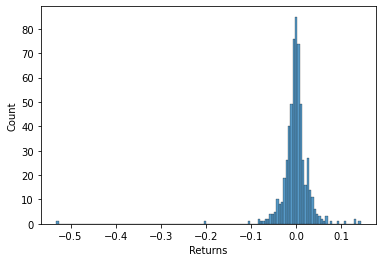

In [26]:
sns.histplot(data=data, x="Returns")

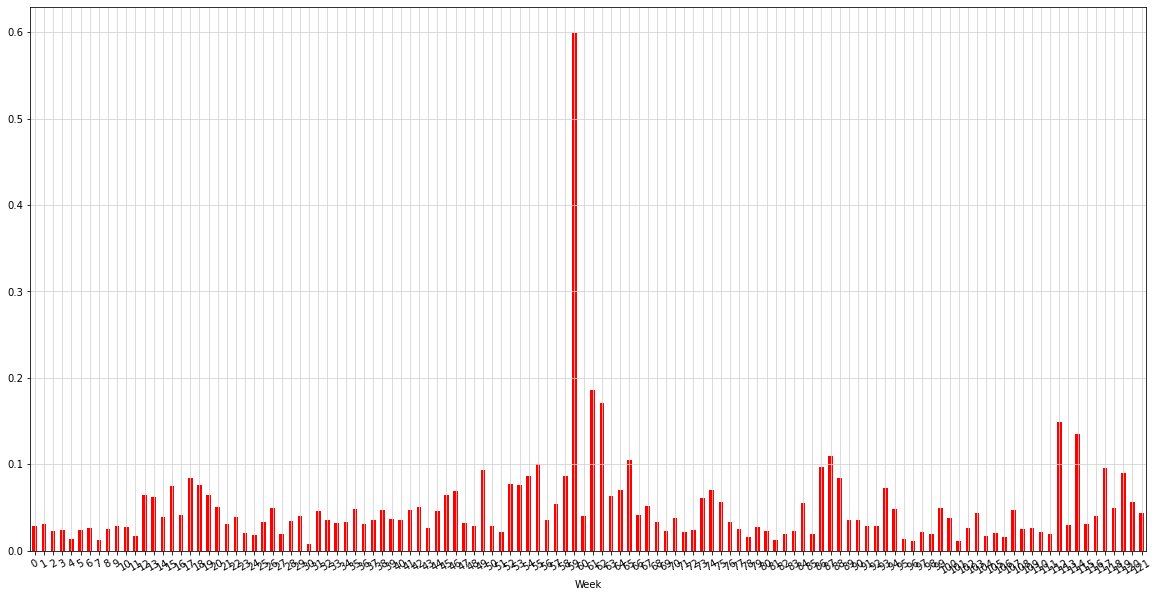

In [27]:
df1.plot.bar(x="Week", y="Returns", color='red', legend=False, figsize=(20, 10), rot=30)
ax = plt.axes()
ax.set_facecolor("white")
plt.grid(color="lightgrey")
plt.show()

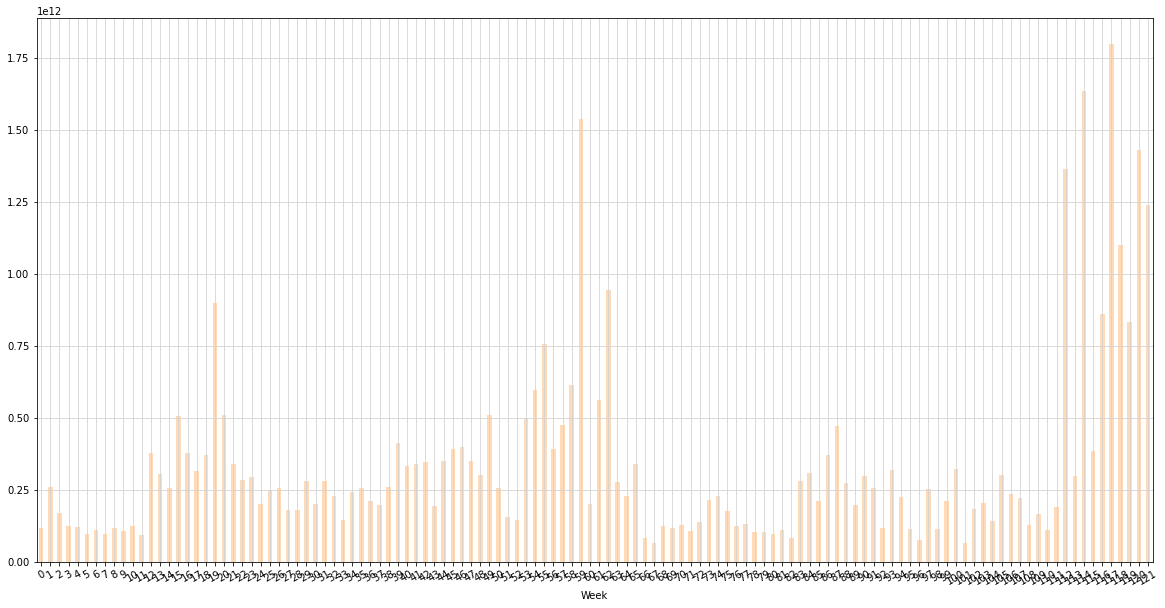

In [46]:
df2.plot.bar(x="Week", y="Volume", color="peachpuff", legend=False, figsize=(20, 10), rot=30)
ax = plt.axes()
ax.set_facecolor("white")
plt.grid(color="lightgrey")
plt.show()


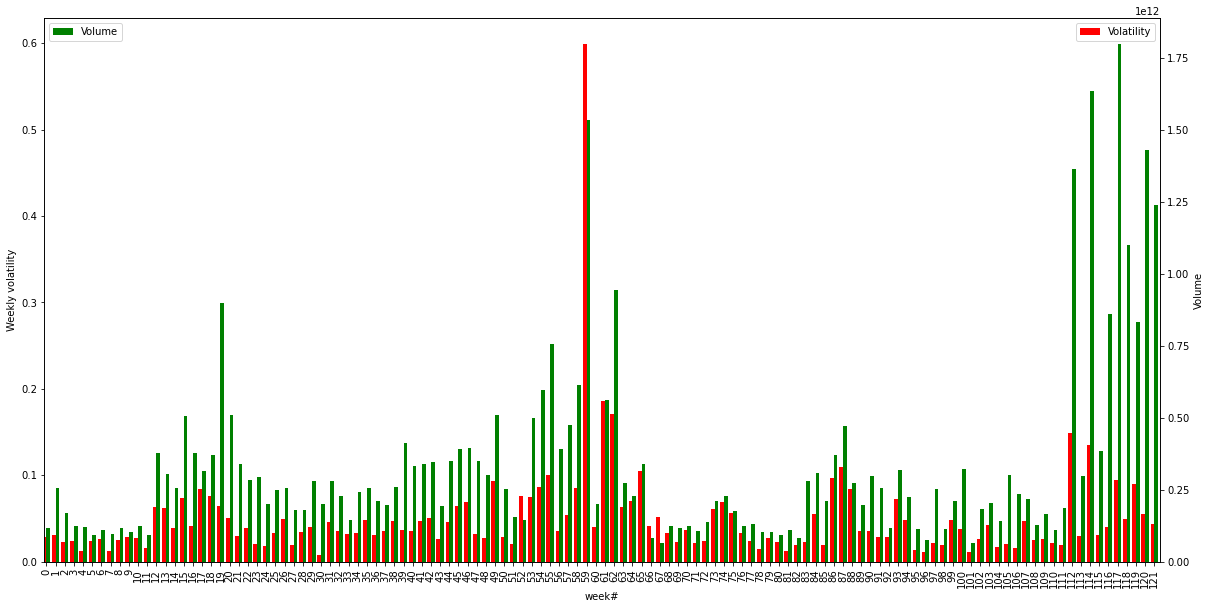

In [50]:
fig = plt.figure(figsize=(20, 10)) # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

width = 0.4

df1.Volatility.plot(kind='bar', color='red', ax=ax, width=width, position=1, legend=True)
df2.Volume.plot(kind='bar', color='green', ax=ax2, width=width, position=0, legend=True)
plt.legend(loc='upper left')

ax.set_ylabel('Weekly volatility')
ax2.set_ylabel('Volume')

plt.show()

# TEST

In [51]:
df1.describe()

,Volatility,Week
count,122.000000,122.000000
mean,0.050088,60.500000
std,0.059180,35.362409
min,0.007285,0.000000
25%,0.024502,30.250000
50%,0.035888,60.500000
75%,0.055790,90.750000
max,0.599185,121.000000


In [31]:
df2.describe()

,Volume,Week
count,1.220000e+02,122.000000
mean,3.363764e+11,60.500000
std,3.278677e+11,35.362409
min,6.560848e+10,0.000000
25%,1.392648e+11,30.250000
50%,2.506151e+11,60.500000
75%,3.502192e+11,90.750000
max,1.799565e+12,121.000000


In [32]:
data.describe()

,Time,Open,High,Low,Price,Volume,Returns,Week,Year,week#
count,589.0,589.000000,589.000000,589.000000,589.000000,5.890000e+02,588.000000,589.000000,589.000000,589.000000
mean,0.0,0.032229,0.032705,0.031634,0.032175,6.967390e+10,-0.000832,24.475382,2021.736842,60.283531
std,0.0,0.014822,0.014986,0.014607,0.014816,8.282766e+10,0.034196,15.107263,0.731007,35.321932
min,0.0,0.014025,0.015060,0.013880,0.014425,3.098040e+09,-0.531944,1.000000,2021.000000,0.000000
25%,0.0,0.017920,0.018200,0.017680,0.017935,2.787958e+10,-0.011485,12.000000,2021.000000,30.000000
50%,0.0,0.023600,0.024145,0.022810,0.023345,4.586541e+10,0.000000,23.000000,2022.000000,60.000000
75%,0.0,0.047990,0.048580,0.047050,0.048000,7.237181e+10,0.010380,37.000000,2022.000000,91.000000
max,0.0,0.057250,0.057500,0.056245,0.057400,7.029108e+11,0.143392,52.000000,2023.000000,121.000000


In [33]:
data["Returns"].skew()

-6.428828876152775

In [34]:
data["Returns"].kurtosis()

101.64172684541491

In [35]:
ret = list(data["Returns"].dropna())

name = ['Jarque-Bera', 'P-value', 'Skew', 'Kurtosis']
test = statsmodels.stats.stattools.jarque_bera(ret)
dict(zip(name, test))

{'Jarque-Bera': 252813.7164343237,
 'P-value': 0.0,
 'Skew': -6.412417167267833,
 'Kurtosis': 103.76929505406238}

In [36]:
# Shapiro normality test
stat, p = shapiro(ret)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')
    

Statistics=0.640, p=0.000
Sample does not look Gaussian (reject H0)


In [37]:
from scipy.stats import norm,t
t.fit(np.array(ret))
print("Parameters from t.fit: ", t.fit(np.array(ret)), "\n") # degrees of freedom, mean, st dev
norm.fit(np.array(ret))
print("Parameters from norm.fit: ", norm.fit(np.array(ret)), "\n")

Parameters from t.fit:  (2.2213992804799556, -9.577289985473442e-05, 0.01393038698213338) 

Parameters from norm.fit:  (-0.0008321520292537935, 0.034166813861123885) 



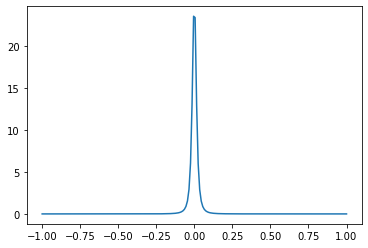

In [38]:
from scipy.stats import norm,t
x=np.linspace(-1, 1, 200)
y=t.pdf(x, 2.2213992804799556, loc=-9.577289985473442e-05, scale=0.01393038698213338)
plt.plot(x,y)

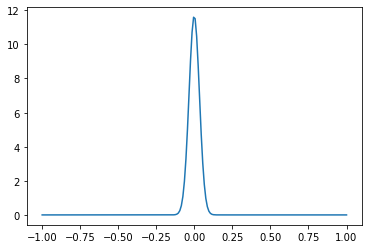

In [39]:
x=np.linspace(-1, 1, 200)
y=norm.pdf(x, loc=-0.0008321520292537935, scale=0.034166813861123885)
plt.plot(x,y)

(array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.08503401,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.08503401,
         0.        ,  0.        ,  0.        ,  0.        ,  0.08503401,
         0.17006803,  0.51020408,  1.53061224,  4.16666667, 18.19727891,
        17.60204082,  5.6122449 ,  1.10544218,  0.42517007,  0.08503401,
         0.08503401,  0.17006803,  0.08503401,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0. 

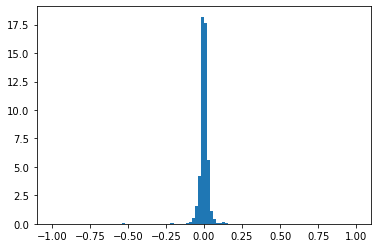

In [40]:
plt.hist(ret, bins=100, range=(-1, 1), density=True)

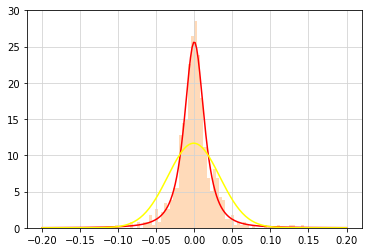

In [41]:
x_min = -0.2
x_max = 0.2
x_t=np.linspace(x_min, x_max, 200)
y_t=t.pdf(x_t, 2.2213992804799556, loc=-9.577289985473442e-05, scale=0.01393038698213338)
x_n=np.linspace(x_min, x_max, 200)
y_n=norm.pdf(x_n, loc=-0.0008321520292537935, scale=0.034166813861123885)
plt.plot(x_t,y_t,c='red')
plt.plot(x_n,y_n,c='yellow')
plt.hist(ret, bins=100, range=(x_min, x_max), density=True, color="peachpuff") #"thistle"
ax = plt.axes()
ax.set_facecolor("white")
plt.grid(color="lightgrey")
plt.show()

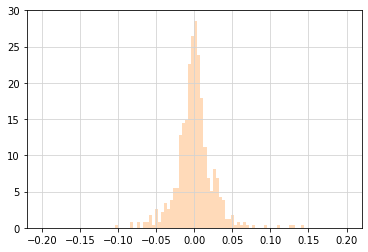

In [42]:
x_min = -0.2
x_max = 0.2
plt.hist(ret, bins=100, range=(x_min, x_max), density=True, color="peachpuff") #"thistle"
ax = plt.axes()
ax.set_facecolor("white")
plt.grid(color="lightgrey")
plt.show()

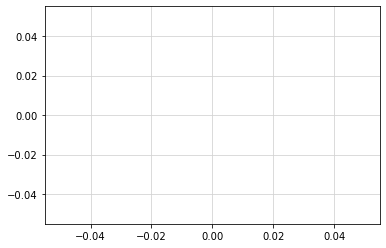

In [43]:
x_min = -0.2
x_max = 0.2
plt.hist(data["Volume"], bins=100, range=(x_min, x_max), density=True, color="peachpuff") #"thistle"
ax = plt.axes()
ax.set_facecolor("white")
plt.grid(color="lightgrey")
plt.show()

In [37]:
dt = pd.read_csv('VTBR_1day_2018.txt', sep=",", parse_dates=['<DATE>'])
dt.columns = ["Ticker", "Per", "Date", "Time", "Open", "High", "Low", "Price", "Volume"]

In [38]:
dt["Year"] = 1
for i in range(0,len(dt.Date)):
    dt["Year"][i] = dt["Date"][i].isocalendar()[0]

In [39]:
dt['Returns'] = np.log(dt['Price']) - np.log(dt['Price'].shift(1))

<AxesSubplot:xlabel='Returns', ylabel='Count'>

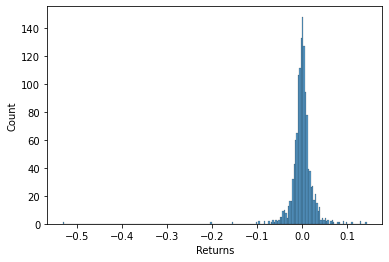

In [40]:
sns.histplot(data=dt, x="Returns")

<AxesSubplot:xlabel='Date', ylabel='Returns'>

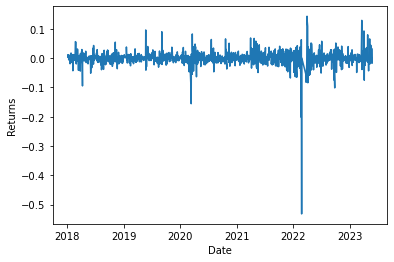

In [41]:
sns.lineplot(data=dt, y="Returns", x="Date")

In [42]:
dt = dt.loc[756:]

<AxesSubplot:xlabel='Date', ylabel='Returns'>

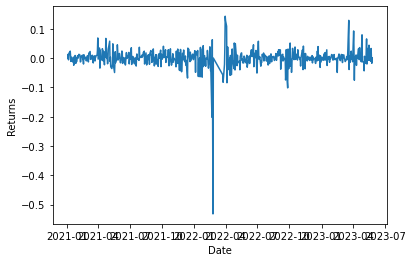

In [43]:
sns.lineplot(data=dt, y="Returns", x="Date")

<AxesSubplot:xlabel='Returns', ylabel='Count'>

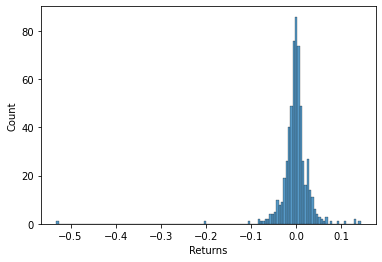

In [44]:
sns.histplot(data=dt, x="Returns")

In [45]:
dt = dt.reset_index()
dt["Time"] = dt.index
dt

,index,Ticker,Per,Date,Time,Open,High,Low,Price,Volume,Year,Returns
0,756,VTBR,D,2021-01-04,0,0.038025,0.038520,0.037800,0.037925,23826040000,2021,0.000791
1,757,VTBR,D,2021-01-05,1,0.037935,0.038600,0.037855,0.038445,28782590000,2021,0.013618
2,758,VTBR,D,2021-01-06,2,0.038525,0.038595,0.038050,0.038235,25428390000,2021,-0.005477
3,759,VTBR,D,2021-01-08,3,0.038520,0.039095,0.038445,0.038940,39504750000,2021,0.018271
4,760,VTBR,D,2021-01-11,4,0.038740,0.040050,0.038410,0.039890,60293350000,2021,0.024104
...,...,...,...,...,...,...,...,...,...,...,...,...
584,1340,VTBR,D,2023-05-22,584,0.023395,0.023480,0.022610,0.022885,170964670000,2023,-0.010649
585,1341,VTBR,D,2023-05-23,585,0.023125,0.023800,0.022800,0.023660,302238790000,2023,0.033304
586,1342,VTBR,D,2023-05-24,586,0.023775,0.024070,0.023290,0.023625,291400320000,2023,-0.001480
587,1343,VTBR,D,2023-05-25,587,0.023600,0.023750,0.022880,0.023220,254696600000,2023,-0.017291
